In [54]:
"""
Plot metabolite progression over time for repeat patients

Instructions
1) Execute this cell.
2) Proceed to Auto Progression for standard ROIs.
    If unsure, run Auto Progression. It will warn you if you need to do Manual Progression or if patient has no past scans.
3) Proceed to Manual Progression for non-standard ROIs.
4) Plot will be displayed in notebook and in the corresponding output/PatientN_YYYYMMDD directory
"""

# Import dependencies
import os
import re
import pandas as pd
from glob import glob
from utils.common import get_2hg_gln_glu, save_plot
from utils.progression import plot_progression

# Read CCS_Proc input and output
study_input_fn = glob(os.path.join(os.path.expanduser('~'), 'mnt/spectro_proc/CCS_Proc/Study_2HG/SVS-PRESS/Input*'))[0]
study_output_fn = glob(os.path.join(os.path.expanduser('~'), 'mnt/spectro_proc/CCS_Proc/Study_2HG/SVS-PRESS/Output*'))[0]
study_input_df = pd.read_excel(study_input_fn)
study_output_df = pd.read_excel(study_output_fn, sheet_name='BestPipeline')

# Auto Progression

In [55]:
"""
Plot progression automatically

Place newly processed patients in the input/ directory and specify metabolites
metabolites: the metabolites to plot, corresponds to the subplots

A plot will be generated if the patient's ROI format contains one SVS with with optional CL.
A plot will have to be manually generated for patients with additional voxels.
A plot will not be generated for patients with only one scan on file.

Example configuration:
    scan_name = 'ClarkS_20210125'
    output_location = 'spectro/users/sam/Report 2HG/output/'
    scan_type = 'svs_se_97'
    metabolites = ['2HG', '2HG/Cr+PCr', '(2HG+Gln)/Glu']
"""

scan_proc = '/external/SFA/SPECTRO_PROC/CCS_AutoProc/output/FloresL_20210519/'
output_location = '/external/SFA/SPECTRO/users/sam/Report 2HG/output/'
scan_type = 'svs_se_97'
metabolites = ['2HG', '2HG/Cr+PCr', '(2HG+Gln)/Glu']
dates_to_exclude = ['20200401']

In [57]:
scan_id = re.search('[a-zA-Z]*_[0-9]{8}', scan_proc).group(0)
patient_name, scan_date = scan_id.split('_')

print(
    f'Scan ID: {scan_id}\n'
    f'Patient Name: {patient_name}\n'
    f'Scan Date: {scan_date}'
)

pt_scans_df = study_input_df[study_input_df['folder'].str.contains(patient_name)]
uncon_rois = pt_scans_df[~pt_scans_df['name'].str.endswith(f'_{scan_type}.dat') & ~pt_scans_df['name'].str.endswith(f'_{scan_type}_CL.dat')]['name'].str.split(f'_{scan_type}_').str[1].str.replace('.dat', '').unique().tolist()

if (len(pt_scans_df) == 0):
    print(
        f'{patient_name} has no past scans.\n'
        f'If this is incorrect, double check that the folder name in input/ matches the past scans in the CCS_Database \'folder\' column.'
    )
elif (len(uncon_rois) > 0):
    print(
        f'{patient_name} has unconventional ROIs {*uncon_rois,}.\n'
        f'Please process this patient manually (see below).'
    )
else:
    data = pd.DataFrame(columns=['date', 'roi', 'metabolite', 'value'])
    for index, row in pt_scans_df.iterrows():
        for met_name in metabolites:
            date = re.search('[0-9]{8}', row['folder']).group(0)
            if (date not in dates_to_exclude):
                data = data.append({
                    'date': date,
                    'roi': 'Lesion' if row['name'].endswith('_svs_se_97.dat') else 'Contralateral',
                    'metabolite': met_name,
                    'value': study_output_df[study_output_df['SpecN'] == index].iloc[0]['(2HG+Gln)/Glu' if met_name == '(2HG+Gln)/Glu' else ' ' + met_name]
                }, ignore_index=True)

    for filename in glob(scan_proc + '*/*.CSV'):
        if (os.path.dirname(filename).endswith('_svs_se_97') or os.path.dirname(filename).endswith('_svs_se_97_CL')):
            file_df = pd.read_csv(filename)

            for met_name in metabolites:
                data = data.append({
                    'date': scan_date,
                    'roi': 'Lesion' if os.path.dirname(filename).endswith('_svs_se_97') else 'Contralateral',
                    'metabolite': met_name,
                    'value': float(get_2hg_gln_glu(file_df)) if met_name == '(2HG+Gln)/Glu' else file_df.iloc[0][' ' + met_name]
                }, ignore_index=True)

    print('Data:')
    display(data.head(len(data)))

    plot = plot_progression(data, metabolites, scan_id)
    print(f'Output: {output_location}{scan_id}/{scan_id}_progression_auto.png')
    plot = save_plot(plot, f'{output_location}{scan_id}/{scan_id}_progression_auto.png')
    plot.show()

Scan ID: FloresL_20210519
Patient Name: FloresL
Scan Date: 20210519
FloresL has unconventional ROIs ('left', 'Left').
Please process this patient manually (see below).


# Manual Progression

In [58]:
"""
Plot progression manually

scan_id: the title of the plot and file output location. Follow the format: PatientN_YYYYMMDD
metabolites: the metabolites to plot, corresponds to the subplots
scan_history: the scan configuration. A numeric value will search in CCS Database by SpecN (index - 2)
    and a string value will search for the first .CSV file in the input/ directory
    
    CCS Database: /spectro_proc/CCS_Proc/Study_2HG/SVS_Press/Input-Study_2HG-YYYYMMDD.xlsx

Example configuration:
    scan_id = 'NicolettiG_20201207'
    metabolites = ['2HG', '2HG/Cr+PCr', '(2HG+Gln)/Glu']
    scan_history = {
        'leftsup': [312, 315, 320, 'NicolettiG_20201207/meas_MID00221_FID257262_svs_se_97_leftsup'],
        'leftsup_CL': [321, 'NicolettiG_20201207/meas_MID00231_FID257272_svs_se_97_leftsup_CL'],
        'postlat': [313, 316, 319, 'NicolettiG_20201207/meas_MID00238_FID257279_svs_se_97_postlat'],
        'postmed': [314, 317, 318, 'NicolettiG_20201207/meas_MID00244_FID257285_svs_se_97_postmed']
    }
"""


scan_id = 'FloresL_20210519'
scan_dir = f'/external/SFA/SPECTRO_PROC/CCS_AutoProc/output/{scan_id}/'
metabolites = ['2HG', '2HG/Cr+PCr', '(2HG+Gln)/Glu']
scan_history = { # Numbers are (index - 2)
    'lesion': [
        207,
        208,
        211,
        214,
        217,
        '/external/SFA/SPECTRO_PROC/CCS_AutoProc/output/FloresL_20210519/meas_MID00698_FID47411_svs_se_97'
    ],
    'left': [
        209,
        213,
        216,
        218,
        '/external/SFA/SPECTRO_PROC/CCS_AutoProc/output/FloresL_20210519/meas_MID00713_FID47426_svs_se_97_left'
    ],
    'CL': [
        210,
        212,
        215,
        219,
        '/external/SFA/SPECTRO_PROC/CCS_AutoProc/output/FloresL_20210519/meas_MID00707_FID47420_svs_se_97_CL'
    ]
}

/external/SFA/SPECTRO_PROC/CCS_AutoProc/output/FloresL_20210519/meas_MID00698_FID47411_svs_se_97/*.CSV
/external/SFA/SPECTRO_PROC/CCS_AutoProc/output/FloresL_20210519/meas_MID00713_FID47426_svs_se_97_left/*.CSV
/external/SFA/SPECTRO_PROC/CCS_AutoProc/output/FloresL_20210519/meas_MID00707_FID47420_svs_se_97_CL/*.CSV


,specn,id,date,roi,metabolite,value
0,207,FloresL_20200902,20200902,lesion,2HG,1.267000
1,207,FloresL_20200902,20200902,lesion,2HG/Cr+PCr,0.160000
2,207,FloresL_20200902,20200902,lesion,(2HG+Gln)/Glu,0.805645
20,209,FloresL_20201021,20201021,left,(2HG+Gln)/Glu,0.814662
33,210,FloresL_20201021,20201021,CL,2HG,5.605000
34,210,FloresL_20201021,20201021,CL,2HG/Cr+PCr,0.278000
35,210,FloresL_20201021,20201021,CL,(2HG+Gln)/Glu,0.497984
19,209,FloresL_20201021,20201021,left,2HG/Cr+PCr,0.201000
18,209,FloresL_20201021,20201021,left,2HG,2.012000
5,208,FloresL_20201021,20201021,lesion,(2HG+Gln)/Glu,0.950416


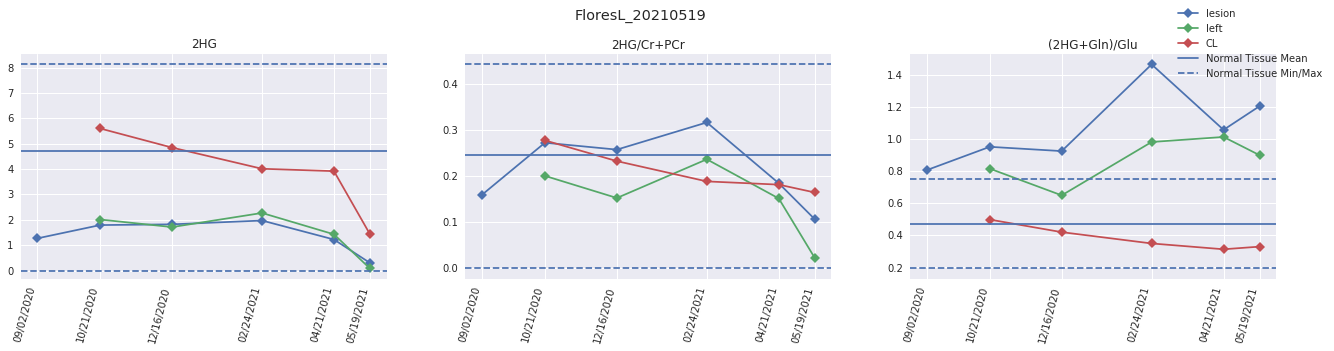

In [59]:
data = pd.DataFrame(columns=['specn', 'id', 'date', 'roi', 'metabolite', 'value'])

for roi, specn_list in scan_history.items():
    for specn in specn_list:
        if (type(specn) == str):
            if (specn.endswith('.CSV')):
                regex = specn
            else:
                regex = f'{specn}/*.CSV'
            print(regex)
            scan_file = glob(regex)[0]
            scan_df = pd.read_csv(scan_file)
        
            for met_name in metabolites:
                data = data.append({
                    'date': re.search('[0-9]{8}', specn).group(0),
                    'roi': roi,
                    'metabolite': met_name,
                    'value': float(get_2hg_gln_glu(scan_df)) if met_name == '(2HG+Gln)/Glu' else scan_df.iloc[0][' ' + met_name]
                }, ignore_index=True)
        else:
            scan_df = study_output_df[study_output_df['SpecN'] == specn].iloc[0]

            for met_name in metabolites:
                data = data.append({
                    'specn': specn,
                    'id': scan_df['ID'],
                    'date': re.search('[0-9]{8}', scan_df['ID']).group(0),
                    'roi': roi,
                    'metabolite': met_name,
                    'value': scan_df['(2HG+Gln)/Glu' if met_name == '(2HG+Gln)/Glu' else ' ' + met_name]
                }, ignore_index=True)
            
data = data.sort_values(by='date')
            
display(data.head(len(data)))

plot = plot_progression(data, metabolites, scan_id)
plot = save_plot(plot, f'output/{scan_id}/{scan_id}_progression_manual.png')
plot.show()